In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Set working directory
import os
os.chdir("C:/Users/Simo/Documents/GitHub/INRE")
# os.chdir("C:/Users/Simone Pagliuca/Documents/GitHub/INRE")

In [275]:
# Define energy classes from A4 to G
energy_classes = ["A4", "A3", "A2", "A1", "B", "C", "D", "E", "F", "G"]

# Number of buildings in the province today is 68967
Buildings = 68967

# Fossil fuel efficiency
efficiency = 0.85

# Heat pump efficiency
COP_cold = 4.5
COP_hot = 3.5

# As of 2025, only 9.58, of the buildings have cooling
cooling_share = 9.58/100 

# Heat Pump share class by class [,]
hp_dist = {
    "A4": 97.40,
    "A3": 91.48,
    "A2": 69.84,
    "A1": 53.05,
    "B": 36.63,
    "C": 32.23,
    "D": 21.32,
    "E": 12.19,
    "F": 6.66,
    "G": 1.77,
}

# Photovoltaic system share class by class [,]
pv_dist = {
    "A4": 96.71,
    "A3": 84.03,
    "A2": 59.73,
    "A1": 43.61,
    "B": 23.98,
    "C": 16.72,
    "D": 7.88,
    "E": 2.63,
    "F": 0.76,
    "G": 0.15,
}

avg_area = 90.99 # m2
avg_epglnren = 245.52 # kWh/m2a

# usage: reference power needed * correction factor = power needed corrected
correction_factors = {
    'A4': avg_area/687,
    'A3': avg_area/210,
    'A2': avg_area/164,
    'A1': avg_area/161,
    'B':  avg_area/243,
    'C':  avg_area/254,
    'D':  avg_area/347,
    'E':  avg_area/306,
    'F':  avg_area/311,
    'G':  avg_area/155
}

photovoltaic_share = {
"A4": 97.03,
"A3": 84.27,
"A2": 61.70,
"A1": 46.90,
"B": 26.70,
"C": 18.42,
"D": 9.08,
"E": 3.40,
"F": 1.07,
"G": 0.40
}

avg_PV_plant_size_HP = 4.3 # kW
avg_PV_plant_size_NO_HP = 3.7 # kW

daily_power = 500e3       # Daily energy demand for ACS (Wh thermal)


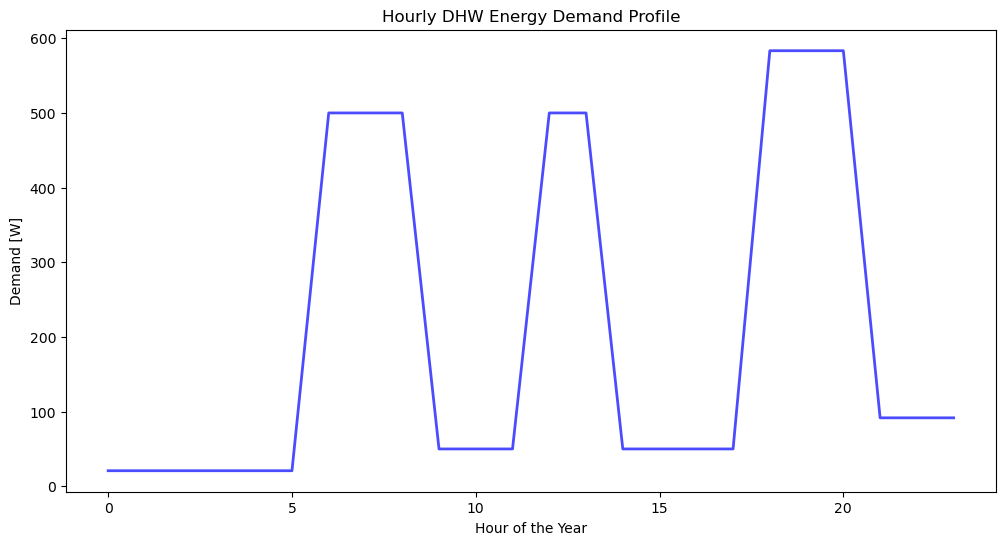

In [276]:
# === PARAMETERS ===
days_per_year = 365

# === USAGE PROFILE ===
# Define % of daily usage per hour (must sum to 100%)
# You can use ranges for convenience
usage_profile_percent = {
    (0, 5): 2.5,    # Night (0.5% x 5 hours)
    (6, 8): 30,     # Morning peak
    (9, 11): 3,     # Low morning
    (12, 13): 20,   # Lunch
    (14, 17): 4,    # Afternoon low
    (18, 20): 35,   # Evening peak
    (21, 23): 5.5   # Late evening
}

# === BUILD HOURLY PROFILE ===
daily_ACS = np.zeros(24)

for hour_range, percent in usage_profile_percent.items():
    start, end = hour_range
    hours_in_range = end - start + 1
    per_hour_value = percent / hours_in_range
    daily_ACS[start:end + 1] = per_hour_value

# Normalize just in case (should sum to 100%)
daily_ACS /= daily_ACS.sum()
# Convert to fraction
daily_ACS /= 100

# === REPEAT FOR YEAR ===
yearly_profile = np.tile(daily_ACS, days_per_year)

# === CALCULATE HOURLY ENERGY DEMAND ===
ACS_demand = yearly_profile * daily_power  # Final result: array of 8760 values

# === PLOT USAGE PROFILE ===
plt.figure(figsize=(12, 6))
plt.plot(ACS_demand[0:24], color='blue', alpha=0.7, linewidth=2)
plt.title("Hourly DHW Energy Demand Profile")
plt.xlabel("Hour of the Year")
plt.ylabel("Demand [W]")
plt.show()

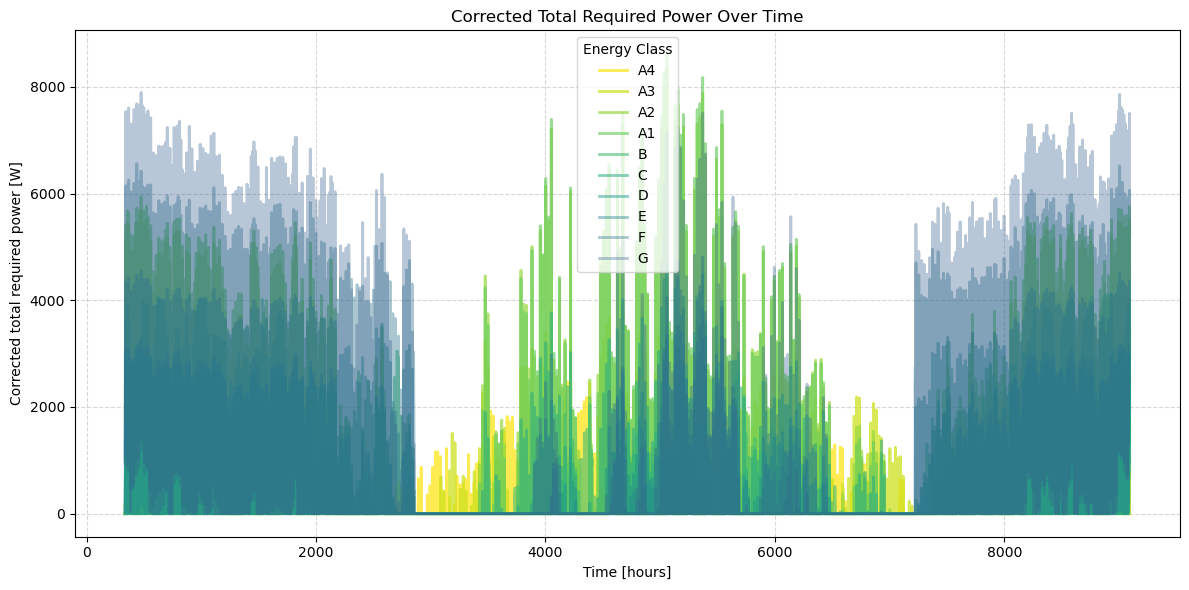

In [277]:
# Create colormap: fade from bold to faint
colors = cm.viridis(np.linspace(1, 0.3, len(energy_classes)))

# Store total_power data and track max for shared y-limit
tot_power = {}
hot_power = {}
cold_power = {}
max_power = 0

# First figure: overlaid curves
plt.figure(figsize=(12, 6))

for i, classe_energetica in enumerate(energy_classes):
    file_path = f".\\Ext_Data\\Termolog_Calcolo_Dinamico_Orario\\{classe_energetica}.xlsx"
    df = pd.read_excel(file_path)

    # Clean column names
    clean_columns = {
        col: col.strip()
                .replace(" ", "_")
                .replace(",", "_")
                .replace("°", "")
                .replace("θ", "theta")
                .replace("Φ", "Phi")
                .replace("χ", "chi")
                .replace("ξ", "xi")
                .replace(".", "_")
                .replace("/", "_")
        for col in df.columns
    }
    df.rename(columns=clean_columns, inplace=True)

    # Compute and apply correction factor
    correction = correction_factors[classe_energetica]
    #+ df["Phi_hum_nd"] + df["Phi_dehum_nd"]



    # Only get steps from 0 to 8759 (1 year)
    df = df[df["step"] >= 0]
    df = df[df["step"] <= 8759]

    # Replace any NaN values with 0
    df["Phi_HC_nd"].fillna(0, inplace=True)

    thermal_power = df["Phi_HC_nd"] * correction
    hot_power_temp = thermal_power.copy()
    cold_power_temp = thermal_power.copy()
    hot_power_temp[hot_power_temp < 0] = 0
    cold_power_temp[cold_power_temp > 0] = 0
    cold_power_temp = abs(cold_power_temp)
    
    total_power = hot_power_temp + cold_power_temp
    hot_power[classe_energetica] = hot_power_temp + ACS_demand
    cold_power[classe_energetica] = cold_power_temp
    tot_power[classe_energetica] = total_power
    max_power = max(max_power, total_power.max())

    # Plot in overlaid figure
    plt.plot(total_power, label=classe_energetica, color=colors[i], alpha=0.8 - i * 0.05, linewidth=2)

plt.legend(title="Energy Class")
plt.xlabel("Time [hours]")
plt.ylabel("Corrected total required power [W]")
plt.title("Corrected Total Required Power Over Time")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(".\\Exports\\Total_Required_Power.png")
plt.show()

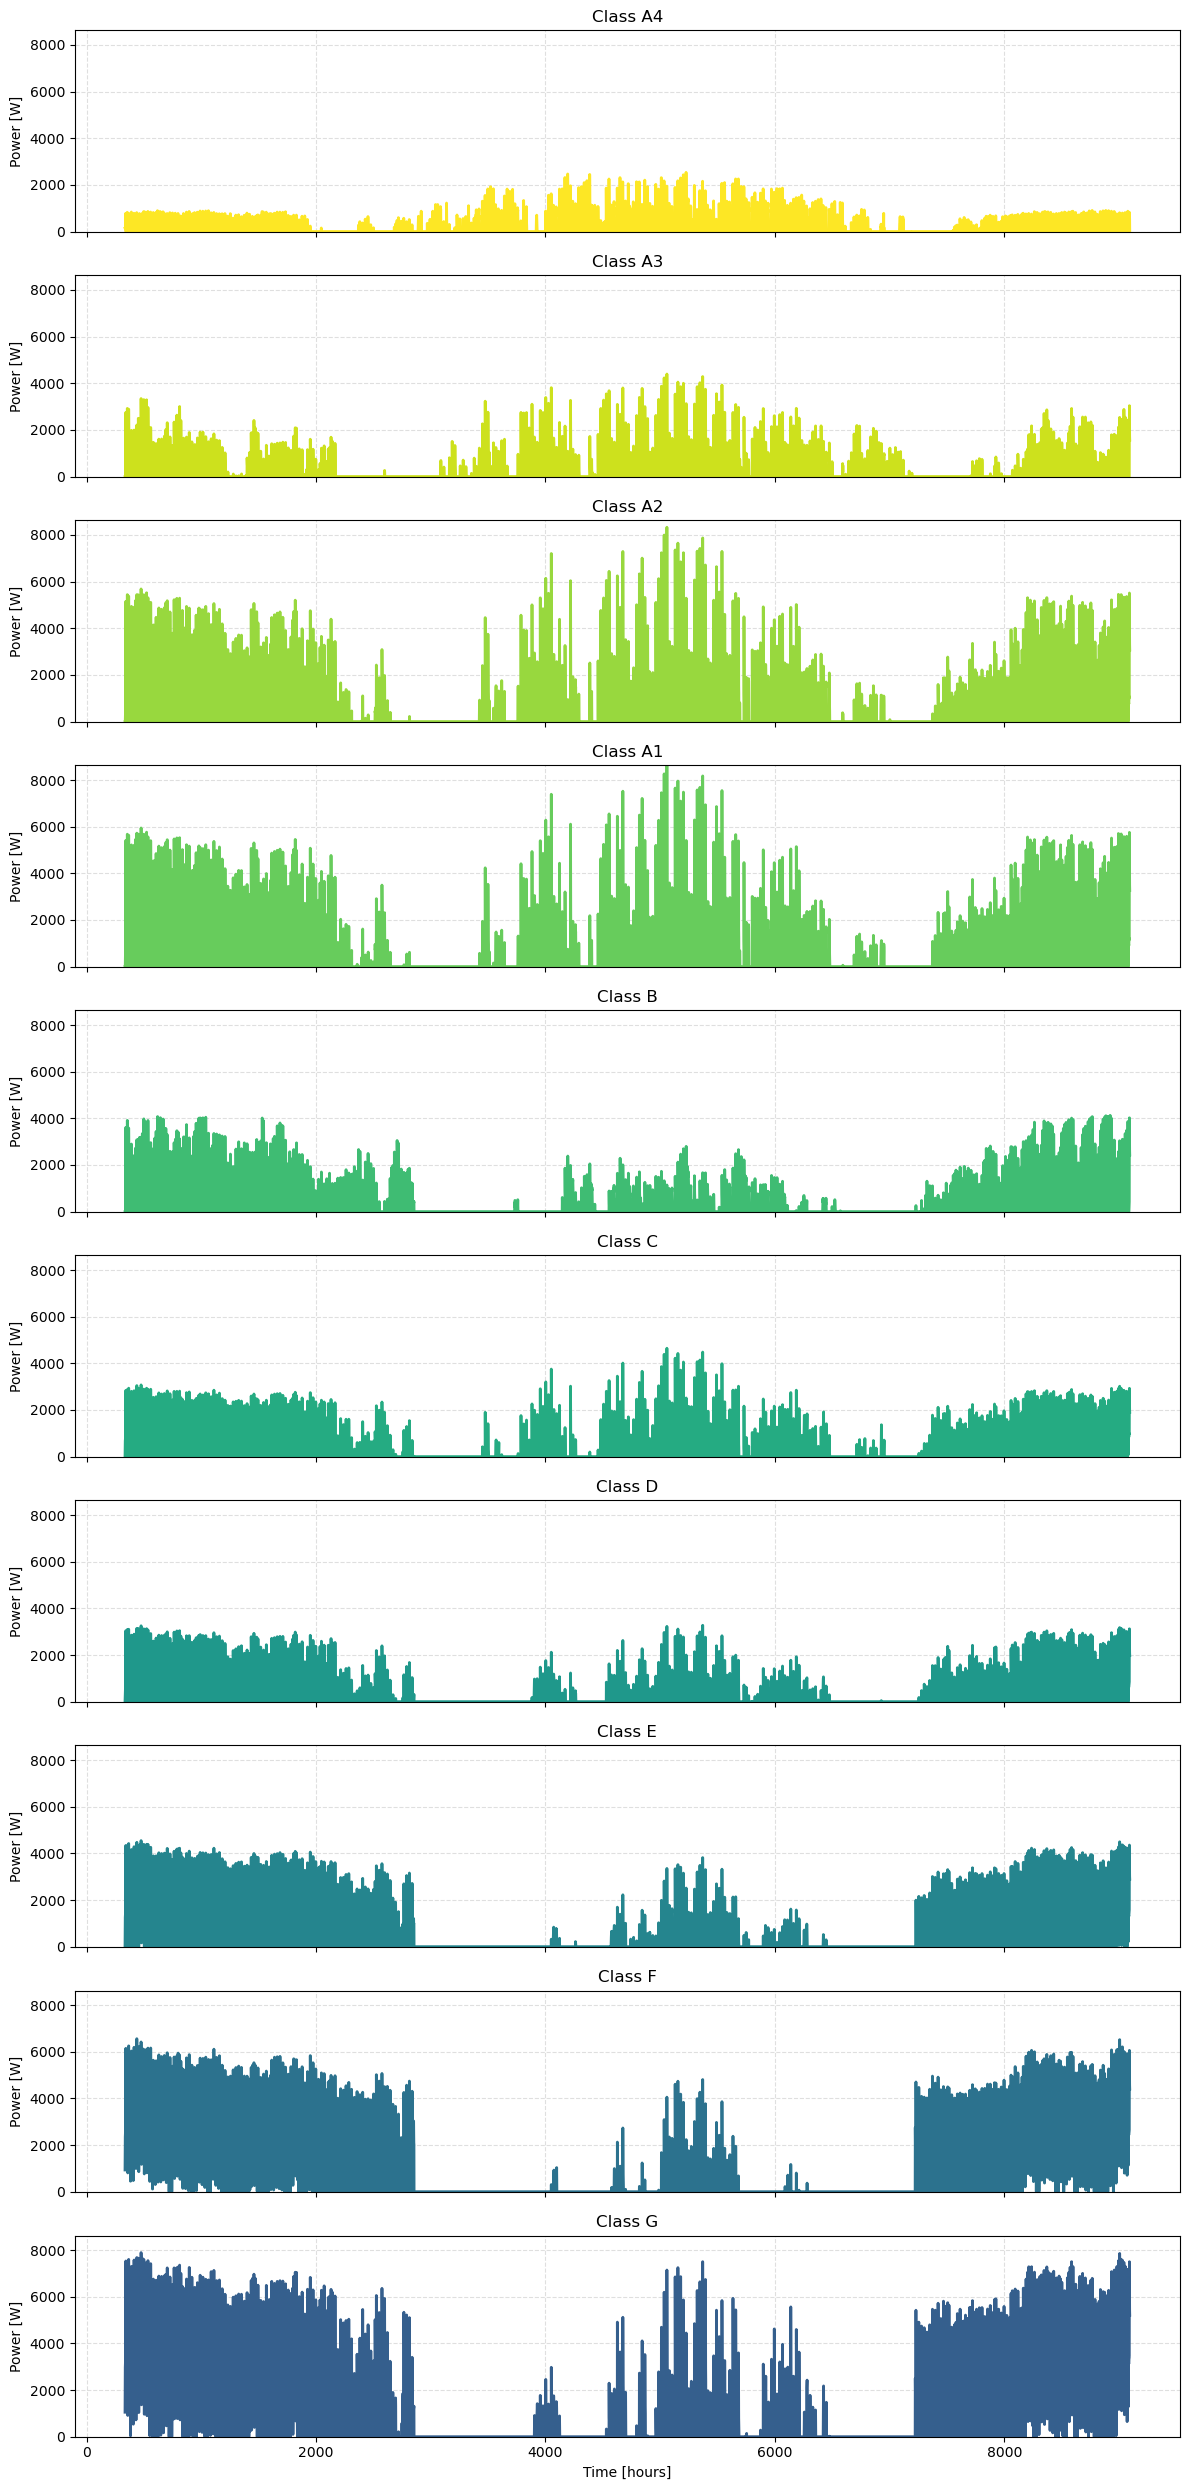

In [278]:
# Second figure: subplots for each class with shared y-axis limit
fig, axes = plt.subplots(len(energy_classes), 1, figsize=(12, 2.5 * len(energy_classes)), sharex=True)

for i, classe in enumerate(energy_classes):
    ax = axes[i]
    ax.plot(tot_power[classe], color=colors[i], linewidth=2)
    ax.set_ylim(0, max_power)
    ax.set_ylabel("Power [W]")
    ax.set_title(f"Class {classe}")
    ax.grid(True, linestyle='--', alpha=0.4)

axes[-1].set_xlabel("Time [hours]")
plt.tight_layout()
plt.savefig(".\\Exports\\Classwise_Energy_Demand.png")
plt.show()


In [279]:
for i, classe in enumerate(energy_classes):
    tot_kwh = sum(tot_power[classe])/1000 # Convert to kWh
    ep = tot_kwh / (avg_area)
    print(f"{classe}: {ep:.2f}")


A4: 15.20
A3: 20.71
A2: 50.01
A1: 53.82
B: 31.39
C: 34.73
D: 29.33
E: 50.79
F: 95.56
G: 113.31


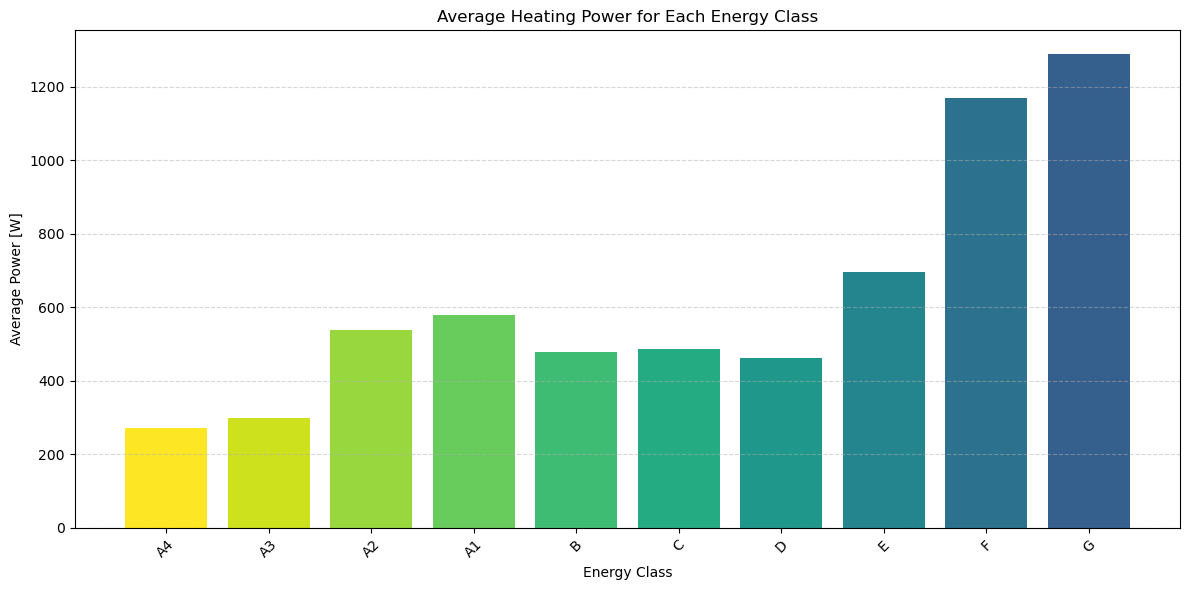

In [280]:
# Add a plot with the average power for each class
plt.figure(figsize=(12, 6))
average_powers = [power[power != 0].mean() for power in hot_power.values()]
plt.bar(energy_classes, average_powers, color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Average Power [W]")
plt.title("Average Heating Power for Each Energy Class")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig(".\\Exports\\Average_Power.png")

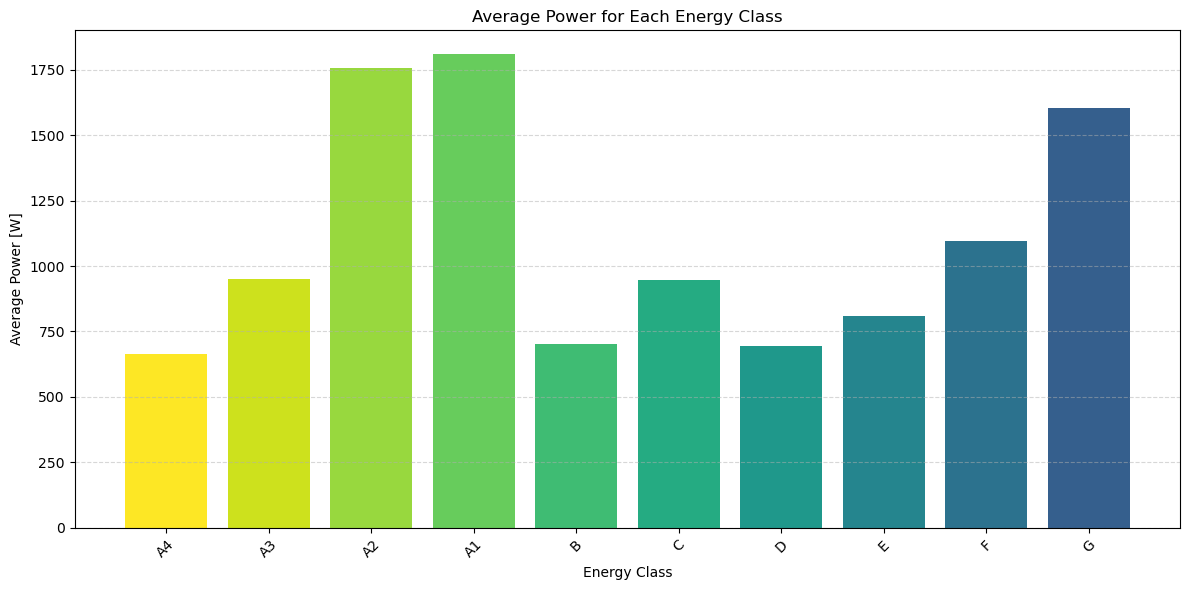

In [281]:
# Add a plot with the average power for each class
plt.figure(figsize=(12, 6))
average_powers = [power[power != 0].mean() for power in cold_power.values()]
plt.bar(energy_classes, average_powers, color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Average Power [W]")
plt.title("Average Power for Each Energy Class")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig(".\\Exports\\Average_Power.png")

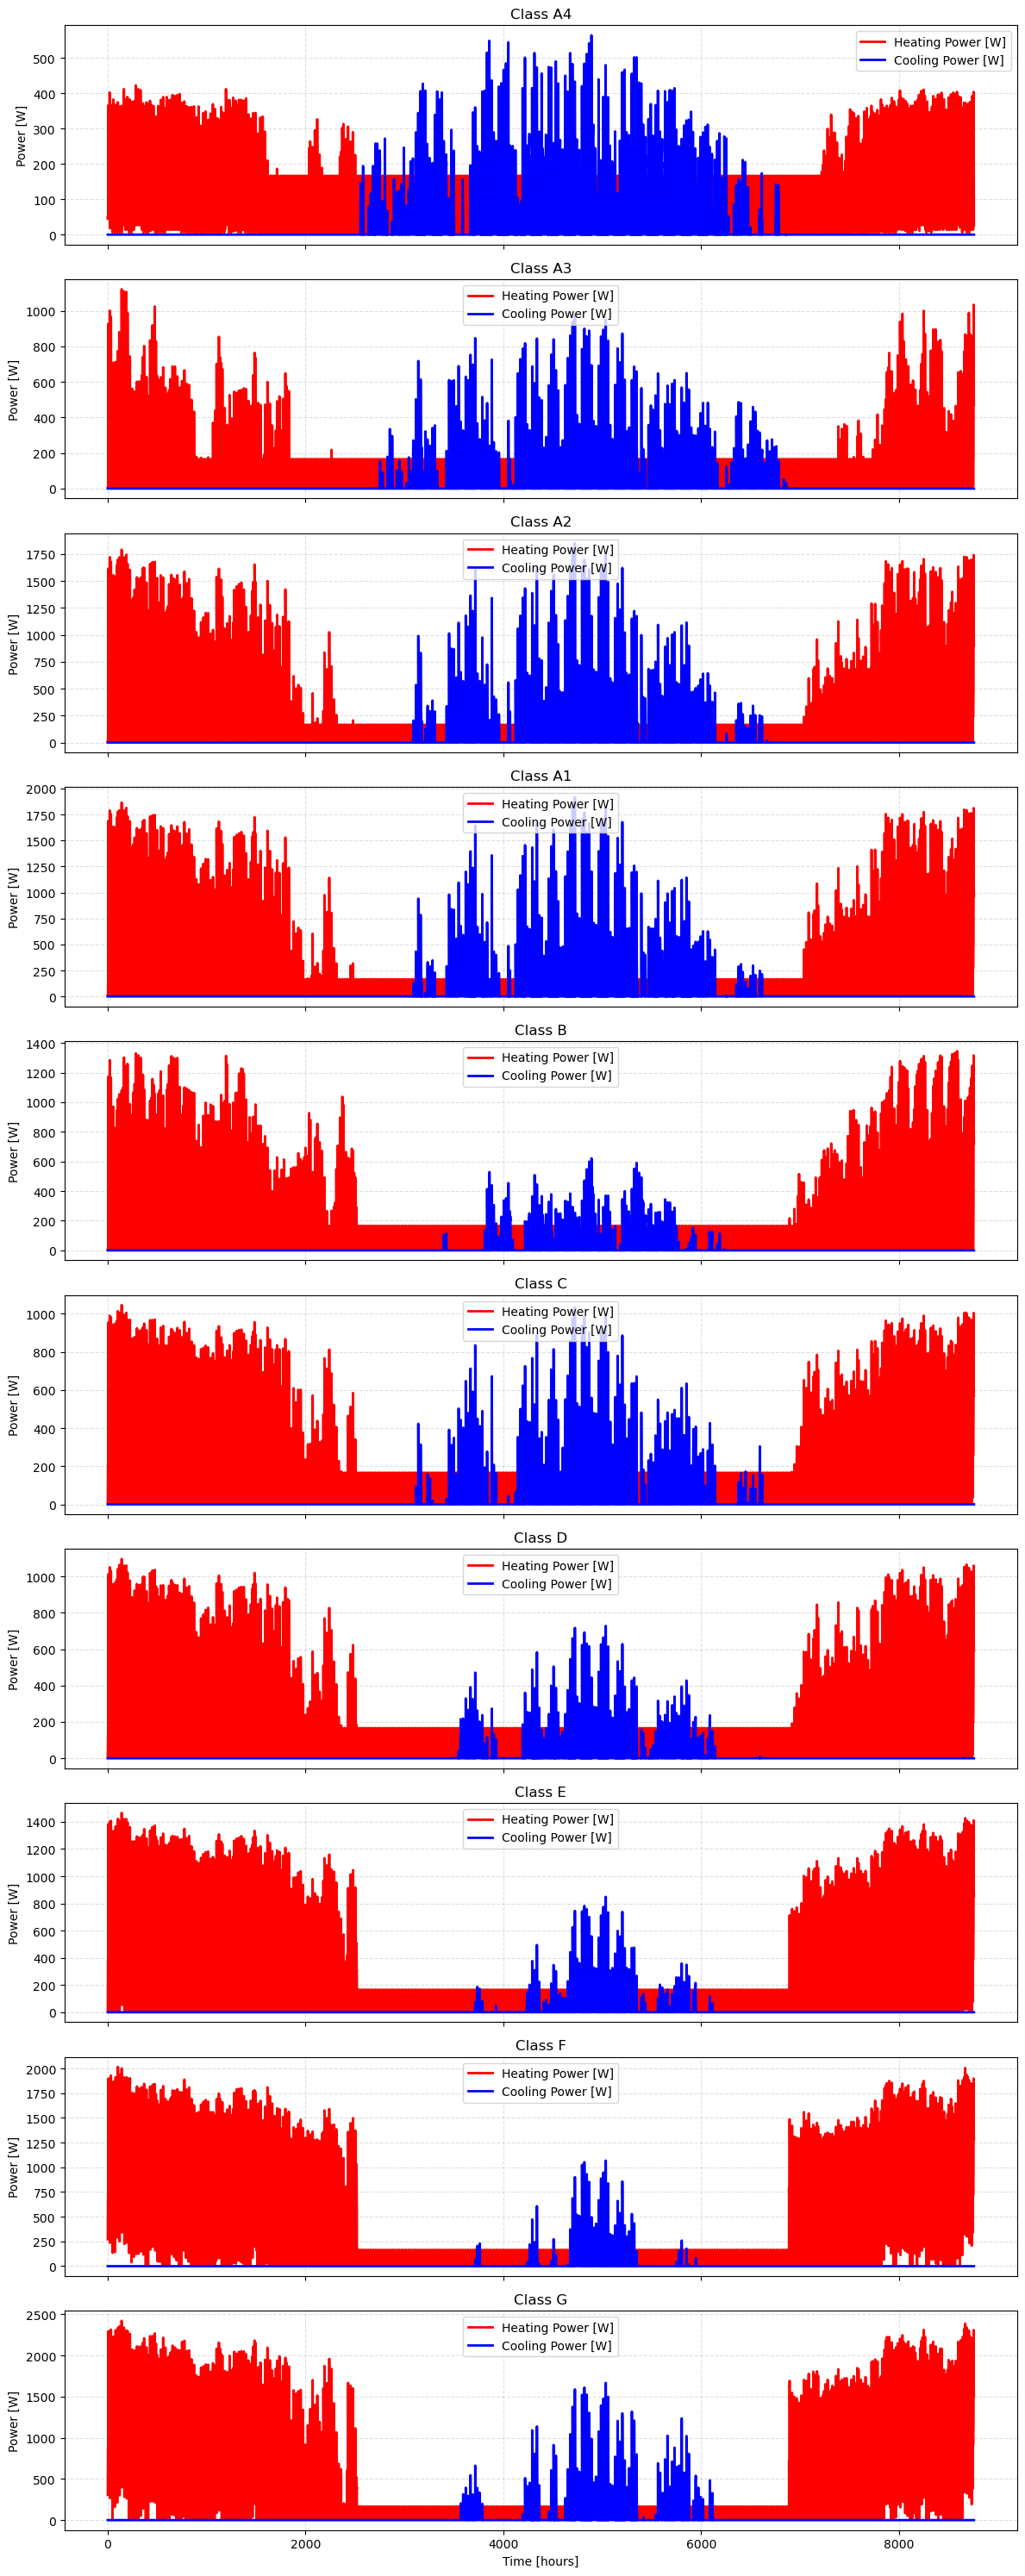

In [282]:
fig, axes = plt.subplots(len(energy_classes), 1, figsize=(12, 3 * len(energy_classes)), sharex=True)
electric_power = {}
for i, classe_energetica in enumerate(energy_classes):
    # Convert to electrical power
    COP_hot = 3.5
    COP_cold = 4.5
    hot_power_e = (hot_power[classe_energetica]) / COP_hot
    cold_power_e = cold_power[classe_energetica] / COP_cold
    electric_power[classe_energetica] = hot_power_e + cold_power_e

    # Plot both on the same subplot
    ax = axes[i]
    ax.plot(hot_power_e.values, label='Heating Power [W]', color='red', linewidth=2)
    ax.plot(cold_power_e.values, label='Cooling Power [W]', color='blue', linewidth=2)
    ax.set_ylabel("Power [W]")
    ax.set_title(f"Class {classe_energetica}")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()

axes[-1].set_xlabel("Time [hours]")
plt.tight_layout()
plt.show()


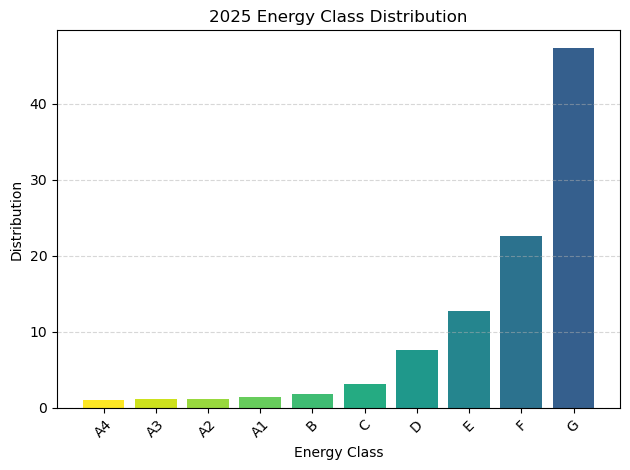

In [283]:
# Create a distribution of energy classes
energy_class_distribution_today = {
"A4": 1.03,
"A3": 1.14,
"A2": 1.14,
"A1": 1.48,
"B": 1.83,
"C": 3.08,
"D": 7.65,
"E": 12.79,
"F": 22.60,
"G": 47.26,
}
# Plot the distribution
# plt.figure(figsize=(12, 6))
plt.bar(energy_class_distribution_today.keys(), energy_class_distribution_today.values(), color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Distribution")
plt.title("2025 Energy Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

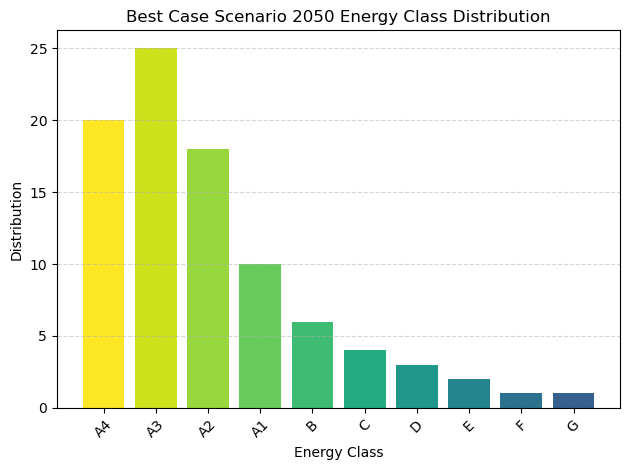

In [284]:
# Create a distribution of energy classes
energy_class_distribution_best = {
    "A4": 20.0,
    "A3": 25.0,
    "A2": 18.0,
    "A1": 10.0,
    "B": 6.0,
    "C": 4.0,
    "D": 3.0,
    "E": 2.0,
    "F": 1.0,
    "G": 1.0,
}
# Plot the distribution
# plt.figure(figsize=(12, 6))
plt.bar(energy_class_distribution_best.keys(), energy_class_distribution_best.values(), color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Distribution")
plt.title("Best Case Scenario 2050 Energy Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

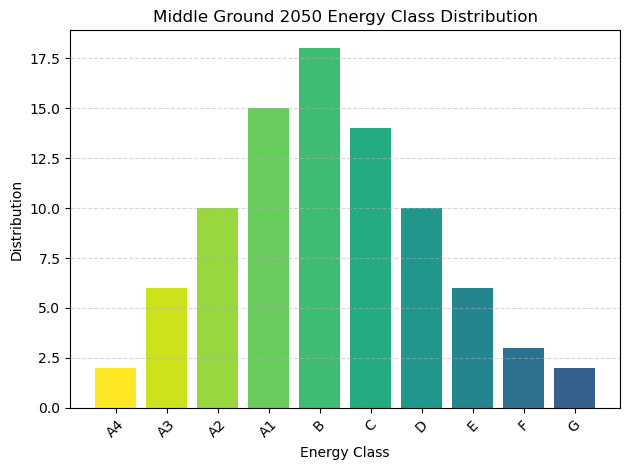

In [285]:
energy_class_distribution_mid = {
    "A4": 2.0,
    "A3": 6.0,
    "A2": 10.0,
    "A1": 15.0,
    "B": 18.0,
    "C": 14.0,
    "D": 10.0,
    "E": 6.0,
    "F": 3.0,
    "G": 2.0,
}
# Plot the distribution
# plt.figure(figsize=(12, 6))
plt.bar(energy_class_distribution_mid.keys(), energy_class_distribution_mid.values(), color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Distribution")
plt.title("Middle Ground 2050 Energy Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

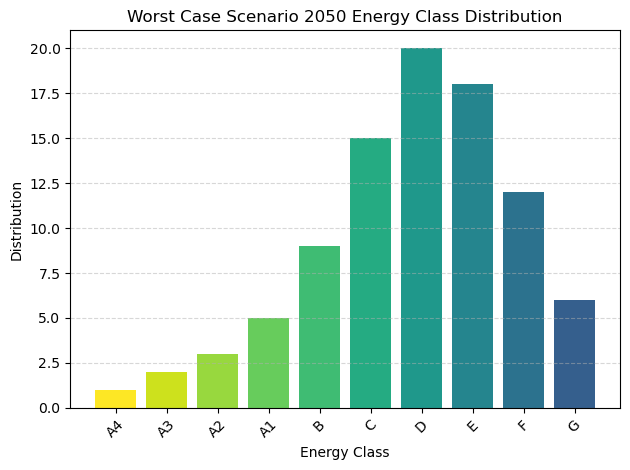

In [286]:
energy_class_distribution_worst = {
    "A4": 1.0,
    "A3": 2.0,
    "A2": 3.0,
    "A1": 5.0,
    "B": 9.0,
    "C": 15.0,
    "D": 20.0,
    "E": 18.0,
    "F": 12.0,
    "G": 6.0,
}
# Plot the distribution
# plt.figure(figsize=(12, 6))
plt.bar(energy_class_distribution_worst.keys(), energy_class_distribution_worst.values(), color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Distribution")
plt.title("Worst Case Scenario 2050 Energy Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

In [287]:
# From this point on we have to choose a distribution to work with, let's say the best one for now
energy_class_distribution = energy_class_distribution_today

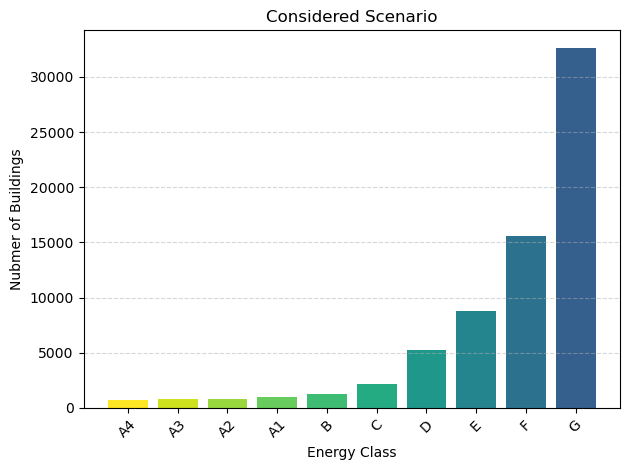

In [288]:
# Scale the distribution to the number of buildings
buildings_per_class = {k: v * Buildings / 100 for k, v in energy_class_distribution.items()}
# Plot the distribution
# plt.figure(figsize=(12, 6))
plt.bar(buildings_per_class.keys(), buildings_per_class.values(), color=colors)
plt.xlabel("Energy Class")
plt.ylabel("Nubmer of Buildings")
plt.title("Considered Scenario")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

8760


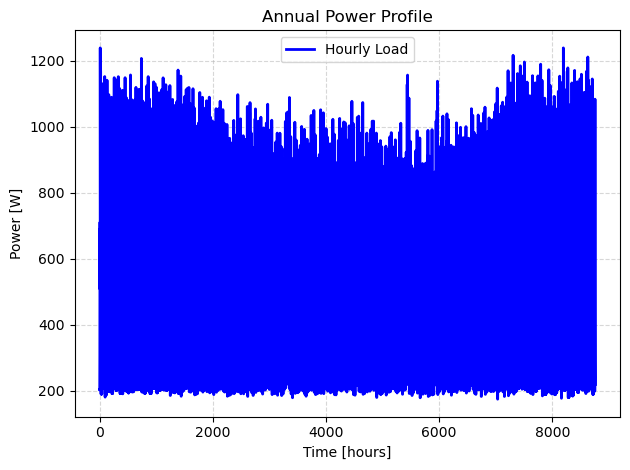

In [289]:
# Assume is the same for all classes
standby = 200
induction_share = 0.35  # percentuale di case con piano a induzione (es. 35,)
induction_profile = np.zeros(24)
induction_profile[7] = 800
induction_profile[12] = 1200
induction_profile[13] = 600
induction_profile[18] = 800
induction_profile[19] = 1000

# Potenza in Watt ora per ora (senza carico di fondo)
winter_weekday_appliances = [
    0, 0, 0, 0, 20, 90, 440, 240, 40, 20, 0, 0,
    0, 0, 0, 0, 20, 40, 340, 540, 440, 240, 90, 20]

winter_weekend_appliances = [
    0, 0, 0, 0, 20, 100, 500, 300, 200, 250, 100, 80,
    300, 400, 200, 150, 100, 150, 350, 550, 450, 300, 120, 50]

fan_load = 100
summer_weekday_appliances = [
    0, 0, 0, 0, 10, 60, 200, 120, 30, 20 + fan_load, fan_load, fan_load,
    fan_load, fan_load, fan_load, fan_load, fan_load, fan_load + 30,
    200 + fan_load, 300 + fan_load, 200 + fan_load, 60 + fan_load, fan_load, fan_load]

summer_holiday_appliances = [
    0, 0, 0, 0, 20, 80, 250, 150, 100, 120 + fan_load, fan_load, fan_load,
    200 + fan_load, 250 + fan_load, fan_load, fan_load,
    100 + fan_load, 150 + fan_load, 250 + fan_load, 350 + fan_load,
    220 + fan_load, 80 + fan_load, fan_load, fan_load]

winter_special_profile = [
    0, 0, 0, 0, 30, 100, 300, 200, 300, 500, 400, 350,
    600, 700, 400, 300, 200, 300, 500, 600, 400, 300, 150, 80]

summer_special_summer = [
    0, 0, 0, 0, 20, 60, 200, 150, 250 + fan_load, 300 + fan_load,
    250 + fan_load, 200 + fan_load, 300 + fan_load, 350 + fan_load,
    250 + fan_load, 200 + fan_load, 180 + fan_load, 220 + fan_load,
    300 + fan_load, 400 + fan_load, 300 + fan_load, 200 + fan_load,
    100 + fan_load, 50]

vacation_factor = 0.86

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

# Date delle festività nel 2025
holidays = {
    '2025-01-01': 'Capodanno',
    '2025-01-06': 'Epifania',
    '2025-04-20': 'Pasqua',
    '2025-04-21': 'Lunedì dell\'Angelo',
    '2025-04-25': 'Festa della Liberazione',
    '2025-05-01': 'Festa dei Lavoratori',
    '2025-06-02': 'Festa della Repubblica',
    '2025-08-15': 'Ferragosto',
    '2025-11-01': 'Ognissanti',
    '2025-12-08': 'Immacolata Concezione',
    '2025-12-25': 'Natale',
    '2025-12-26': 'Santo Stefano'
}

# Settimane di ferie estive
vacation_weeks = [
    ('2025-07-28', '2025-08-03'),
    ('2025-08-04', '2025-08-10'),
    ('2025-08-11', '2025-08-17'),
    ('2025-08-18', '2025-08-24'),
    ('2025-08-25', '2025-08-31'),
    ('2025-09-01', '2025-09-07')
]

# Funzione per determinare se una data è durante le ferie estive
def is_vacation(date):
    for start, end in vacation_weeks:
        if start <= date.strftime('%Y-%m-%d') <= end:
            return True
    return False

# Funzione S-shaped (sigmoide) per la transizione vacanza
def vacation_blend_factor(date):
    for start, end in vacation_weeks:
        start_date = datetime.strptime(start, "%Y-%m-%d")
        end_date = datetime.strptime(end, "%Y-%m-%d")
        total_days = (end_date - start_date).days + 1
        if start_date <= date <= end_date:
            x = (date - start_date).days / total_days
            return 1 - 1 / (1 + np.exp(-10 * (x - 0.5)))
    return 0

# Funzione per transizione stagionale
def seasonal_blend_factor(date):
    day_of_year = date.timetuple().tm_yday
    if 60 <= day_of_year <= 120:
        return (day_of_year - 60) / (120 - 60)
    elif 120 < day_of_year < 273:
        return 1.0
    elif 273 <= day_of_year <= 304:
        return 1.0 - (day_of_year - 273) / (304 - 273)
    else:
        return 0.0

# Profilo annuale
other_electric_needs = []
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 12, 31)
current_date = start_date

rng = np.random.default_rng(seed=42)  # riproducibilità

while current_date <= end_date:
    date_str = current_date.strftime('%Y-%m-%d')
    weekday = current_date.weekday()
    is_holiday = date_str in holidays
    season_blend = seasonal_blend_factor(current_date)
    vac_blend = vacation_blend_factor(current_date)

    if is_holiday:
        daily_profile = summer_special_summer if season_blend > 0.5 else winter_special_profile
    else:
        if weekday < 5:
            winter_day = winter_weekday_appliances
            summer_day = summer_weekday_appliances
        else:
            winter_day = winter_weekend_appliances
            summer_day = summer_holiday_appliances

        daily_profile = [
            (1 - season_blend) * w + season_blend * s
            for w, s in zip(winter_day, summer_day)
        ]

    if vac_blend > 0:
        daily_profile = [(1 - vac_blend * (1 - vacation_factor)) * val for val in daily_profile]

    # Aggiungi variazione giornaliera casuale per rappresentare giornate buone o cattive (es. meteo)
    weather_factor = rng.normal(loc=1.0, scale=0.05)  # variazione ±5% circa

    daily_profile = [weather_factor * (val + standby + (induction_share * induction_profile[i])) for i, val in enumerate(daily_profile)]
    other_electric_needs.extend(daily_profile)
    current_date += timedelta(days=1)

# Convert to DataFrame and resample to hourly data
other_electric_needs = pd.Series(other_electric_needs)
print(len(other_electric_needs))
# Plot finale con curva media
plt.plot(other_electric_needs, color='blue', linewidth=2, label="Hourly Load")
plt.xlabel("Time [hours]")
plt.ylabel("Power [W]")
plt.title("Annual Power Profile")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# n=1
# plt.xlim(0+24*n,24+24*n)
plt.show()


In [290]:
# Determine teh damnds of fossil and electric power
fossil_fuel_demand = {}
electric_demand = {}

total_electric_demand = 0
total_fossil_fuel_demand = 0

for energy_class, share in energy_class_distribution.items():
    fossil_fuel_demand[energy_class] = hot_power[energy_class] / efficiency
    electric_demand[energy_class] = hot_power[energy_class] / COP_hot + cooling_share * cold_power[energy_class] / COP_cold
    # Scale by the number of buildings * the share of the class
    fossil_fuel_demand[energy_class] *= buildings_per_class[energy_class] * (1-hp_dist[energy_class]/100)
    electric_demand[energy_class] *= buildings_per_class[energy_class] * (hp_dist[energy_class])
    electric_demand[energy_class] +=  other_electric_needs * buildings_per_class[energy_class]
    # Add to the total
    total_electric_demand += electric_demand[energy_class]
    total_fossil_fuel_demand += fossil_fuel_demand[energy_class]   

for i, classe in enumerate(energy_classes):
    tot_kwh = sum(fossil_fuel_demand[classe])/1000 # Convert to kWh/annum
    ep = tot_kwh / (avg_area*buildings_per_class[energy_class])
    print(f"{classe}: {ep:.3f}")


A4: 0.017
A3: 0.070
A2: 0.444
A1: 0.967
B: 1.330
C: 2.433
D: 6.668
E: 18.748
F: 59.157
G: 143.459


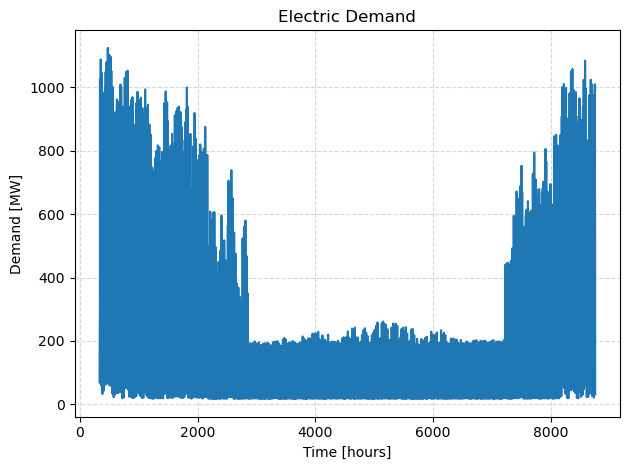

In [291]:

# Plot the smoothed total demand of electricity and fossil fuels
# plt.figure(figsize=(12, 6))
plt.plot(total_electric_demand/1e6, label="Electric Demand")
plt.xlabel("Time [hours]")
plt.ylabel("Demand [MW]")
plt.title("Electric Demand")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

In [292]:
# Average electric demand
total_by_household = total_electric_demand.sum() / Buildings
display(f"Total Yearly Electric Demand per Household {(total_by_household / 1e3):.2f} kWh")

'Total Yearly Electric Demand per Household 19454.97 kWh'

In [293]:
total_electric_demand = total_electric_demand/total_by_household * 5000e3

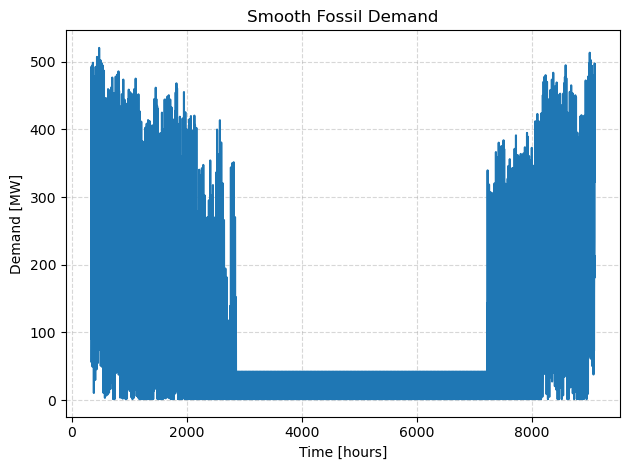

In [294]:
plt.plot(total_fossil_fuel_demand/1e6, label="Fossil Demand")
plt.xlabel("Time [hours]")
plt.ylabel("Demand [MW]")
plt.title("Smooth Fossil Demand")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

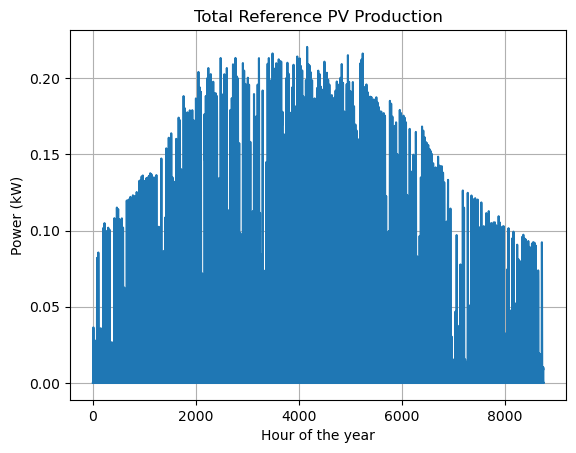

In [295]:
# Read Solar generation curve
df = pd.read_csv("Ext_Data/Tot_PV_Production.csv")

# Extract the 'Power' column and convert it to a list
Hourly_ref_PV_production = df['Power'].tolist()

# Plot the total PV production
plt.plot(Hourly_ref_PV_production)
plt.title("Total Reference PV Production")
plt.xlabel("Hour of the year")
plt.ylabel("Power (kW)")
plt.grid(True)

In [296]:
Total_PV = np.zeros(8760)
# Calculate the total PV production for each energy class
for energy_class, share in energy_class_distribution.items():
    # Scale the PV production by the share of the class and the number of buildings
    PV_production = np.array(Hourly_ref_PV_production) * buildings_per_class[energy_class] * photovoltaic_share[energy_class] / 100
    # Scale by the dimention of the plant
    PV_production *= hp_dist[energy_class]/100 * avg_PV_plant_size_HP + (1-hp_dist[energy_class]/100) * avg_PV_plant_size_NO_HP
    # Add to the total demand
    Total_PV += PV_production

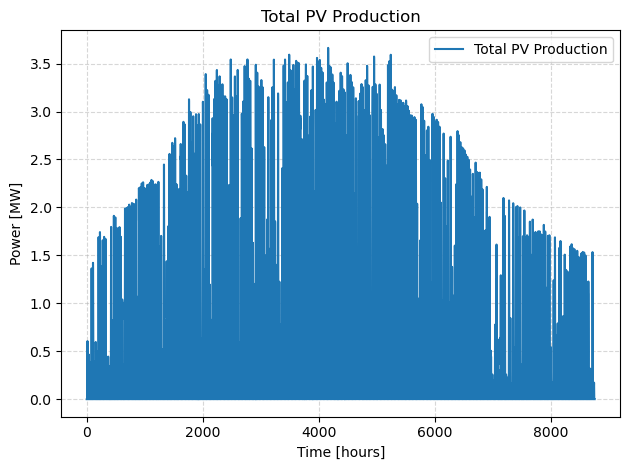

In [297]:
# Plot total PV production
plt.plot(Total_PV / 1000, label="Total PV Production")
plt.xlabel("Time [hours]")
plt.ylabel("Power [MW]")
plt.title("Total PV Production")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

In [298]:
print(len(Total_PV))
print(len(total_electric_demand))

8760
8760


In [299]:
# Calculate the net grid balance
Net_grid = total_electric_demand/(2*1e6) - Total_PV/1e3 # So it is in MW

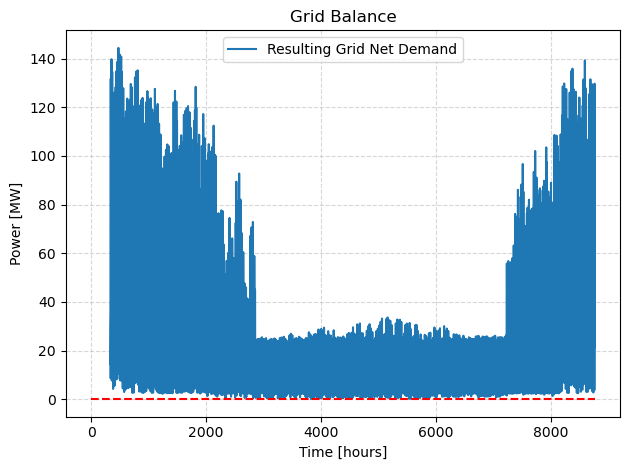

In [300]:
# Plot the resulting grid net demand
plt.plot(Net_grid, label="Resulting Grid Net Demand")
plt.xlabel("Time [hours]")
plt.ylabel("Power [MW]")
plt.title("Grid Balance")
plt.grid(True, linestyle='--', alpha=0.5)
plt.hlines(0, 0, len(Net_grid), colors='red', linestyles='dashed')
plt.legend()
plt.tight_layout()

In [301]:
# Average electric demand
total_by_household = Net_grid.sum() / Buildings
display(f"Total Yearly Electric Demand per Household {(total_by_household * 1e3):.2f} kWh")

'Total Yearly Electric Demand per Household 2418.71 kWh'

In [302]:
# Create an interactive plot with Plotly where i can select a day [0+24*n,24+24*n]
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'browser'

# Create a DataFrame for the data
df = pd.DataFrame({
    'Hour': np.arange(len(Net_grid)),
    'Net_Grid': Net_grid,
    'Electric_Demand': total_electric_demand / 1e6,
    'PV_Production': Total_PV / 1000
})
# Create the figure
fig = go.Figure()
# Add traces for each line
fig.add_trace(go.Scatter(x=df['Hour'], y=df['Net_Grid'], mode='lines', name='Net Grid Demand', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df['Hour'], y=df['Electric_Demand'], mode='lines+markers', name='Electric Demand', line=dict(color='orange', dash='dash')))
fig.add_trace(go.Scatter(x=df['Hour'], y=df['PV_Production'], mode='lines', name='PV Production', line=dict(color='green', dash='dash')))
# Add a horizontal line at y=0
fig.add_hline(y=0, line_color='red', line_width=2, line_dash='dash')
# Update layout
fig.update_layout(
    title='Net Grid Demand, Electric Demand and PV Production',
    xaxis_title='Hour of the Year',
    yaxis_title='Power [MW]',
    legend_title='Legend',
    hovermode='x unified',
    template='plotly_white'
)
# Show the figure
fig.show()
# Save the figure as an HTML file
fig.write_html(".\\Exports\\Net_Grid_Demand.html")

In [303]:
# Save the net grid data in a csv file
df.to_csv(".\\Exports\\Net_Grid_Demand.csv", index=False)

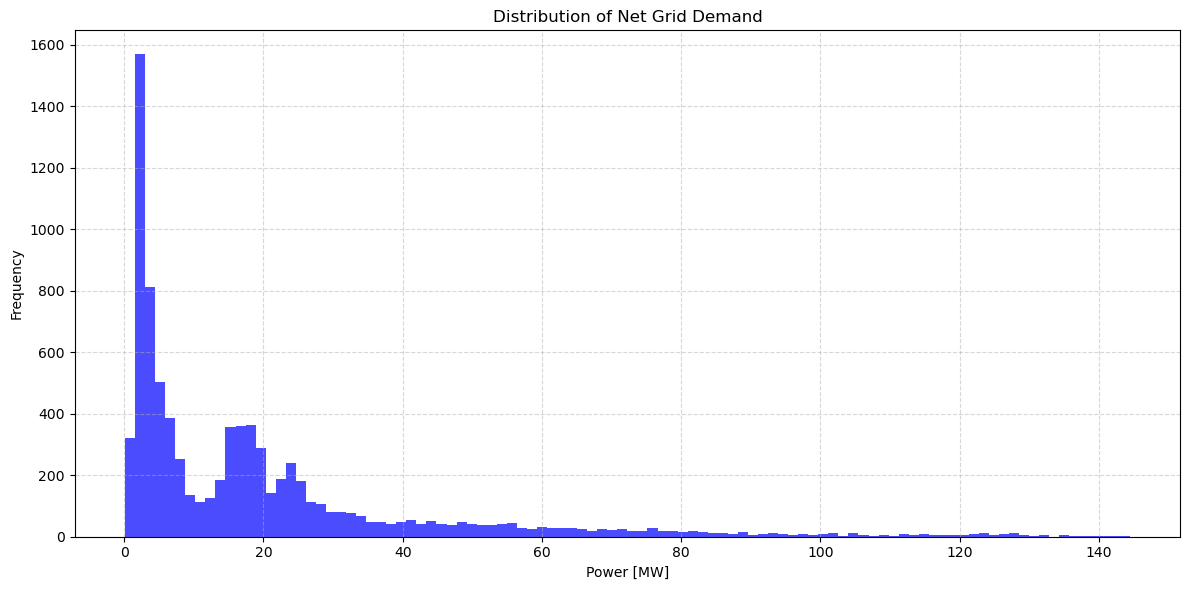

In [304]:
# Distribution of the power - make an histogram of the net grid demand
plt.figure(figsize=(12, 6))
plt.hist(Net_grid, bins=100, color='blue', alpha=0.7)
plt.xlabel("Power [MW]")
plt.ylabel("Frequency")
plt.title("Distribution of Net Grid Demand")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig(".\\Project_Data\\Plots\\Distribution_of_Net_Grid_Demand.png")
plt.show()